# 進階房價預測

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd



from scipy.stats import skew

from scipy.special import boxcox1p

from sklearn.feature_selection import RFECV

from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score



train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')





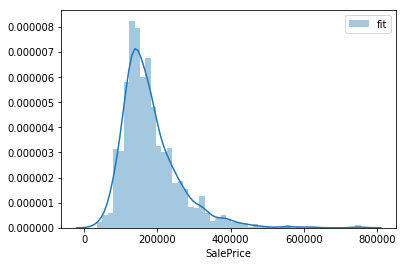

In [2]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot(train['SalePrice'])
plt.legend(["fit", "dist"])

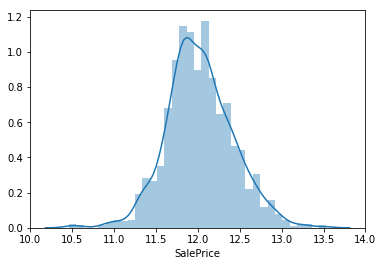

In [3]:
sns.distplot(np.log1p(train["SalePrice"]))

In [4]:
# remove outliers

#train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]



all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],

                      test.loc[:,'MSSubClass':'SaleCondition']))



# drop some features to avoid multicollinearity

#all_data.drop(['1stFlrSF', 'GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)



train["SalePrice"] = np.log1p(train["SalePrice"])



numeric_feats = all_data.dtypes[all_data.dtypes != "object"].drop(["MSSubClass"]).index



skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

skewed_feats = skewed_feats[skewed_feats > 0.65]

skewed_feats = skewed_feats.index



all_data[skewed_feats] = boxcox1p(all_data[skewed_feats], 0.15)




all_data = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data,  columns=["MSSubClass"])



all_data = all_data.fillna(all_data.mean())
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#imp = IterativeImputer()
#all_data = imp.fit_transform(all_data)  




X_train = all_data[:train.shape[0]]

X_test = all_data[train.shape[0]:]

y = train.SalePrice





#### models selection

lasso = Lasso(alpha=0.0004)

model = lasso



### prediction

model.fit(X_train, y)



preds = np.expm1(model.predict(X_test))

solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})

solution.to_csv("full_features_lasso_new.csv", index = False)